# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Columns Info
Data columns (total 18 columns):
 
 id,
 region,
 price,
 year,
 manufacturer,
 model,
 condition,
 cylinders,
 fuel,
 odometer,
 title_status,
 transmission,
 VIN,
 drive,
 type,
 paint_color,
 state

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [437]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # Often used alongside Seaborn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [443]:
df=pd.read_csv('data/vehicles.csv')


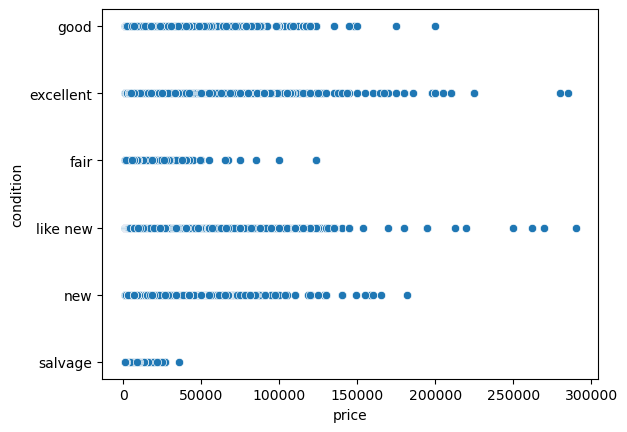

In [444]:
df_price_range = df[df["price"].between(1000, 300000)]   # Remove extreme outliers for better plots
ax=sns.scatterplot(x='price',y='condition', data=df_price_range)
# While the general trend is clear, there's still a spread of prices within each condition category. 
# This suggests that other factors beyond just the broad condition categories might also 
# influence the final price (e.g., specific features, make/model if it were cars, mileage, etc.)
plt.show()

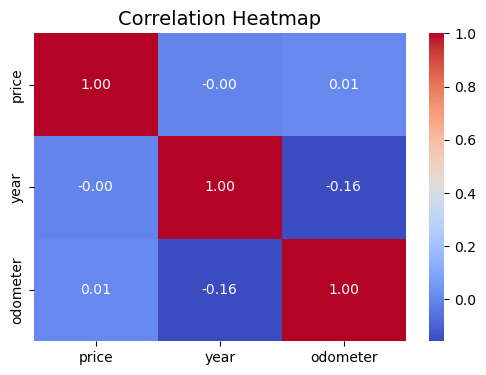

In [445]:
#df.info()
corr_columns=["price","year","odometer"]
df_crr=df[corr_columns]
plt.figure(figsize=(6, 4))
sns.heatmap(df_crr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()


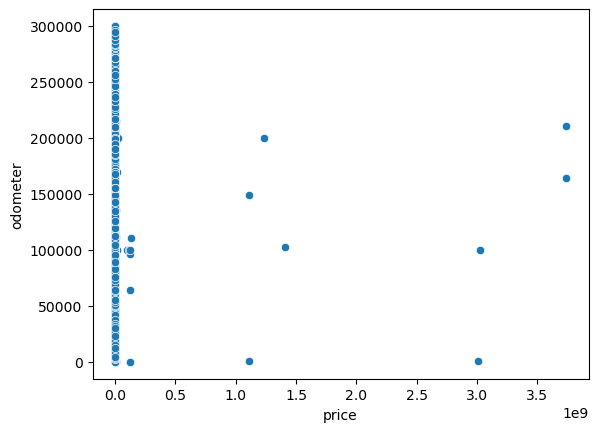

In [446]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df_price_odo_range = df[df["price"].between(1000, 200000)]   # Remove extreme outliers for better plots
df_price_odo_range = df[df["odometer"].between(0, 300000)]   # Remove extreme outliers for better plots
ax=sns.scatterplot(x='price',y='odometer', data=df_price_odo_range)

# While the general trend is clear, there's still a spread of prices within each condition category. 
# This suggests that other factors beyond just the broad condition categories might also 
# influence the final price (e.g., specific features, make/model if it were cars, mileage, etc.)
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [447]:
#df=df.drop('VIN',axis=1)
print('Before dropping na')
print(len(df))
df=df.dropna()
print('After dropping na')
print(len(df))
print('Before dropping duplicates')
print(len(df))
df=df.drop_duplicates()
print('After dropping duplicates')
print(len(df))
df.info()

Before dropping na
426880
After dropping na
34868
Before dropping duplicates
34868
After dropping duplicates
34868
<class 'pandas.core.frame.DataFrame'>
Index: 34868 entries, 126 to 426836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34868 non-null  int64  
 1   region        34868 non-null  object 
 2   price         34868 non-null  int64  
 3   year          34868 non-null  float64
 4   manufacturer  34868 non-null  object 
 5   model         34868 non-null  object 
 6   condition     34868 non-null  object 
 7   cylinders     34868 non-null  object 
 8   fuel          34868 non-null  object 
 9   odometer      34868 non-null  float64
 10  title_status  34868 non-null  object 
 11  transmission  34868 non-null  object 
 12  VIN           34868 non-null  object 
 13  drive         34868 non-null  object 
 14  size          34868 non-null  object 
 15  type          34868 non-null  object 
 16 

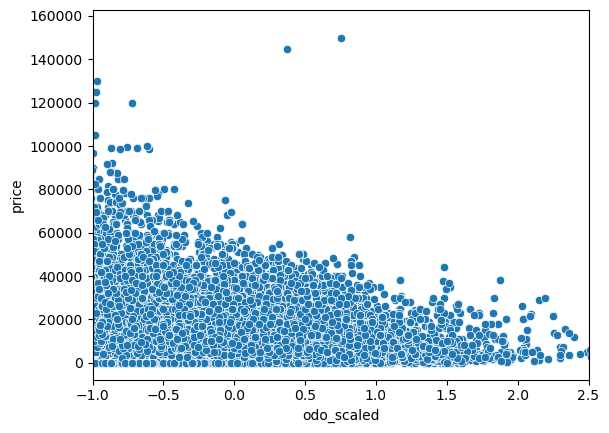

In [448]:
# standardize odometer values to better view the correlation
scaler = StandardScaler()
df['odo_scaled'] =scaler.fit_transform(df[['odometer']])
df.drop('odometer',axis=1,inplace=True)
ax=sns.scatterplot(x='odo_scaled',y='price', data=df)
plt.xlim(-1.0, 2.5)
plt.show()
# Here we can observe the negative correlation between odometer and price. As odometer increases
# price decreases.

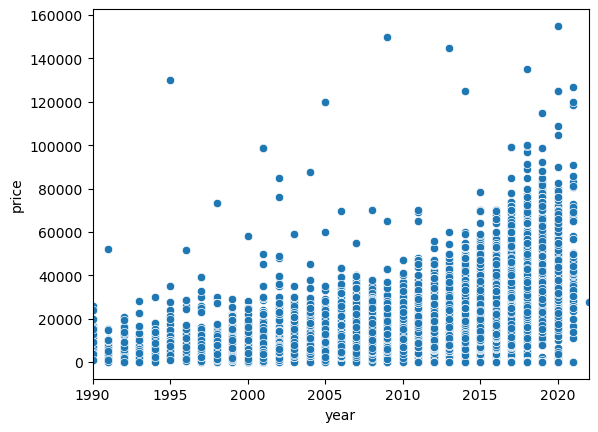

In [449]:
ax=sns.scatterplot(x='year',y='price', data=df)
plt.xlim(1990, 2022)

# While the general trend is clear, old vehicles are relatively less expensive.
# we also observe occassionally, some old vehicles are also expensive. This may be influenced by other factors.
# But in general, as we become more current, the general trend of the price of the vehicles is becoming expensive.
# indicating newer vehicle prices are more then older vehicles.
plt.show()

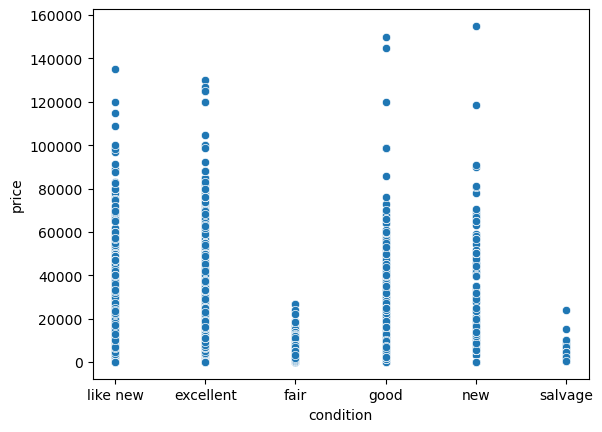

In [450]:
ax=sns.scatterplot(x='condition',y='price', data=df)

# Clearly new , like new, excellent condition cars tend to have higher price
# then good, fair, salvage cars.
plt.show()

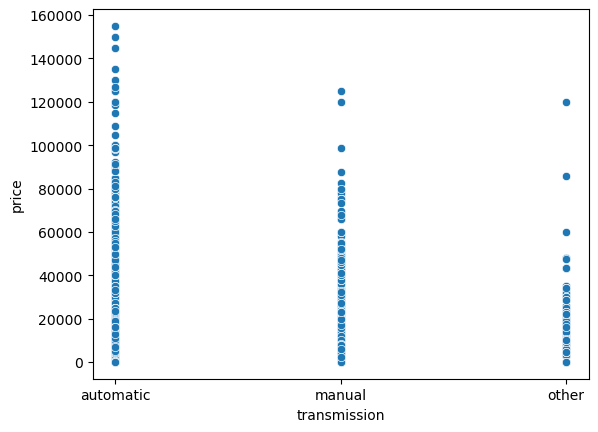

In [451]:
ax=sns.scatterplot(x='transmission',y='price', data=df)

# Clearly clean title cars have higher prices than lien,rebuilt, missing and parts only
plt.show()

In [452]:
iqr = ''

###BEGIN SOLUTION

first_quartile = df['odo_scaled'].quantile(.25)
third_quartile = df['odo_scaled'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr

outliers_filtered = df.loc[(df['odo_scaled']>lower) & (df['odo_scaled']<upper)]

first_quartile = outliers_filtered['year'].quantile(.25)
third_quartile = outliers_filtered['year'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr

outliers_filtered = outliers_filtered.loc[(df['year']>lower) & (df['year']<upper)]


print(len(outliers_filtered))
# count in salaries_no_outlier 34516
# while count in original df is 34868. So we managed to remove 350 outliers.

33667


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [453]:
outliers_filtered = outliers_filtered.dropna(subset=["price", "year", "odo_scaled", "condition", "cylinders"])
# Features and target
X = outliers_filtered.drop("price", axis=1)
y = outliers_filtered["price"]

# Identify column groups
ordinal_cols = ["condition", "title_status"]   # Label encoded
onehot_cols = ["transmission"]                 # One-hot encoded

numeric_cols = ["year","odo_scaled"]

# Label encode 'condition' and 'title_status'
for col in ["condition", "title_status"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Preprocessor: Different transforms per column type
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), onehot_cols),
    ("scaler", StandardScaler(), numeric_cols)
])

# Full pipeline
#    ("lr", LinearRegression(),
#    ("pca", PCA(n_components=4)),

pipe = Pipeline([
    ("preprocess", preprocessor), 
    ("poly",PolynomialFeatures(degree=10,include_bias=False)),
    ("ridge", Ridge(alpha=1.0, random_state=42, max_iter=10000))
])
#    

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
pipe.fit(X_train, y_train)
# Step 1: Get feature names after preprocessing
ohe_features = pipe.named_steps["preprocess"].named_transformers_["onehot"].get_feature_names_out(onehot_cols)
scaled_features = numeric_cols  # already known
all_features = list(ohe_features) + scaled_features

print("Preprocessed feature names:", all_features)

# # Predict 
y_pred = pipe.predict(X_test)

# # Evaluate
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Preprocessed feature names: ['transmission_manual', 'transmission_other', 'year', 'odo_scaled']
MSE: 132695943.57044305
R2 Score: 0.2518946279351414


34868
34868
150208407.76530823
Predicted price: $26,897.07


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.